In [1]:
!pip3 install polygon-api-client pandas requests matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd
import requests
from polygon import RESTClient
import matplotlib.pyplot as plt

/Users/brunoinzunza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
#Polygon API
api_key = os.getenv('POLYGON_API_KEY')
client = RESTClient(api_key)

In [6]:
def data(ticker='C:EURUSD', timespan='minute', from_date='2023-01-01', to_date='2024-01-01', limit=50000):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    data = response.json()
    df = pd.DataFrame(data['results'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, inplace=True)
    df.drop(columns=['vw', 'n', 't'], inplace=True)
    return df

data = data()
data

,Volume,Open,Close,High,Low,timestamp
0,35,1.07209,1.07208,1.07211,1.07198,2023-05-29 00:00:00
1,24,1.07209,1.07203,1.07210,1.07190,2023-05-29 00:01:00
2,28,1.07210,1.07205,1.07210,1.07190,2023-05-29 00:02:00
3,25,1.07204,1.07205,1.07209,1.07190,2023-05-29 00:03:00
4,21,1.07206,1.07190,1.07210,1.07190,2023-05-29 00:04:00
...,...,...,...,...,...,...
49995,101,1.12240,1.12242,1.12250,1.12220,2023-07-17 00:58:00
49996,132,1.12243,1.12247,1.12253,1.12220,2023-07-17 00:59:00
49997,166,1.12250,1.12269,1.12269,1.12230,2023-07-17 01:00:00
49998,128,1.12270,1.12264,1.12274,1.12250,2023-07-17 01:01:00


In [7]:
def signals(df, window=20, num_std=2):
    df['SMA'] = df['Close'].rolling(window).mean()
    df['STD'] = df['Close'].rolling(window).std()

    df['Upper Band'] = df['SMA'] + (df['STD'] * num_std)
    df['Lower Band'] = df['SMA'] - (df['STD'] * num_std)

    df['Buy Signal'] = (df['Close'] < df['Lower Band'])   
    df['Sell Signal'] = (df['Close'] > df['Upper Band']) 

    return df

data_w_signals = signals(data)
data_w_signals

,Volume,Open,Close,High,Low,timestamp,SMA,STD,Upper Band,Lower Band,Buy Signal,Sell Signal
0,35,1.07209,1.07208,1.07211,1.07198,2023-05-29 00:00:00,NaN,NaN,NaN,NaN,False,False
1,24,1.07209,1.07203,1.07210,1.07190,2023-05-29 00:01:00,NaN,NaN,NaN,NaN,False,False
2,28,1.07210,1.07205,1.07210,1.07190,2023-05-29 00:02:00,NaN,NaN,NaN,NaN,False,False
3,25,1.07204,1.07205,1.07209,1.07190,2023-05-29 00:03:00,NaN,NaN,NaN,NaN,False,False
4,21,1.07206,1.07190,1.07210,1.07190,2023-05-29 00:04:00,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,101,1.12240,1.12242,1.12250,1.12220,2023-07-17 00:58:00,1.122633,0.000102,1.122836,1.122429,True,False
49996,132,1.12243,1.12247,1.12253,1.12220,2023-07-17 00:59:00,1.122625,0.000108,1.122841,1.122409,False,False
49997,166,1.12250,1.12269,1.12269,1.12230,2023-07-17 01:00:00,1.122623,0.000107,1.122837,1.122410,False,False
49998,128,1.12270,1.12264,1.12274,1.12250,2023-07-17 01:01:00,1.122631,0.000103,1.122836,1.122425,False,False


In [8]:
def backtest(df, initial_balance=10000):
    position = 0
    entry_price = 0
    realized_gains = 0
    trades = []

    for i in range(1, len(df)):
        trade_data = {}

        if df['Buy Signal'][i] and position != 1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = 1
            if(position == -1):
                profit = entry_price - df['Close'][i]
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = 1
            entry_price = df['Close'][i]

        elif df['Sell Signal'][i] and position != -1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = -1
            if(position == 1):
                profit = df['Close'][i] - entry_price
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = -1
            entry_price = df['Close'][i]

    trade_df = pd.DataFrame(trades)

    return trade_df

backtest_results = backtest(data_w_signals)
backtest_results

,Time,Price,Position,Realized,Balance,Profit,Result
0,2023-05-29 00:35:00,1.07204,-1,0.00000,10000.00000,NaN,NaN
1,2023-05-29 01:44:00,1.07281,1,-0.00077,9999.99923,-0.00077,Loss
2,2023-05-29 02:02:00,1.07344,-1,-0.00014,9999.99986,0.00063,Win
3,2023-05-29 02:33:00,1.07310,1,0.00020,10000.00020,0.00034,Win
4,2023-05-29 03:16:00,1.07336,-1,0.00046,10000.00046,0.00026,Win
...,...,...,...,...,...,...,...
1063,2023-07-16 22:43:00,1.12253,1,0.09815,10000.09815,0.00127,Win
1064,2023-07-16 23:30:00,1.12285,-1,0.09847,10000.09847,0.00032,Win
1065,2023-07-16 23:53:00,1.12260,1,0.09872,10000.09872,0.00025,Win
1066,2023-07-17 00:40:00,1.12272,-1,0.09884,10000.09884,0.00012,Win


In [9]:
def analysis(trade_df, initial_balance=10000):
    num_trades = len(trade_df)
    winrate = ((trade_df['Result'] == "Win").sum() / num_trades) * 100
    final_balance = trade_df['Balance'].tail(1).values[0]
    net_returns = final_balance - initial_balance
    percent_return = (final_balance / initial_balance)
    avg_profit_per_trade = net_returns / num_trades
    largest_win = trade_df['Profit'].max()
    largest_loss = trade_df['Profit'].min()
    print(f'Winrate: {winrate}%')
    print(f'Final Balance: {final_balance}')
    print(f'Net Returns: {net_returns}')
    print(f'Percentage Returns: {percent_return}%')
    print(f'Total Trades: {num_trades}')
    print(f'Average Profit per Trade: {avg_profit_per_trade}')
    print(f'Largest Win: {largest_win}')
    print(f'Largest Loss: {largest_loss}')

analysis(backtest_results)

Winrate: 70.31835205992509%
Final Balance: 10000.09915
Net Returns: 0.09915000000000873
Percentage Returns: 1.000009915%
Total Trades: 1068
Average Profit per Trade: 9.283707865169356e-05
Largest Win: 0.0028799999999999937
Largest Loss: -0.007209999999999939


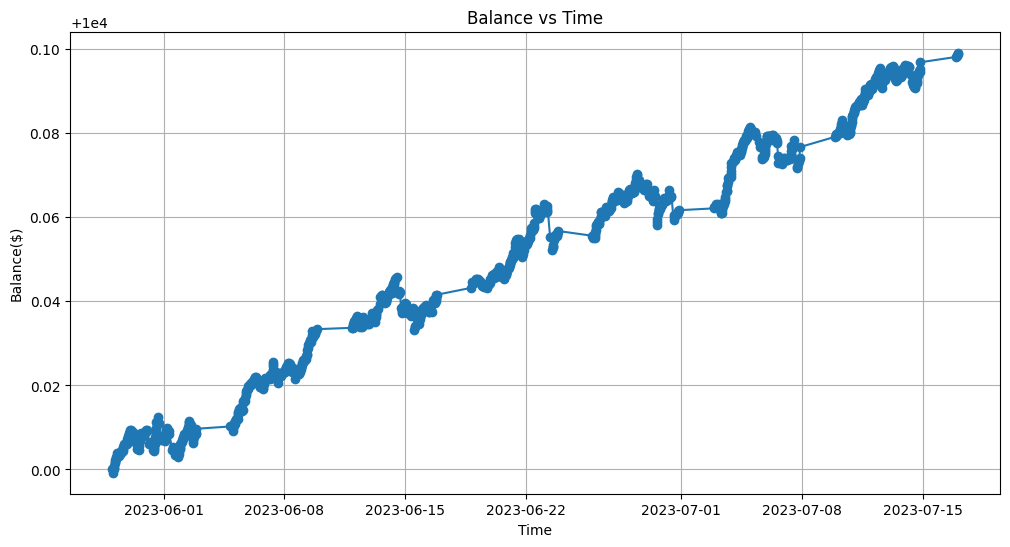

In [10]:
def plots(trade_df):
    plt.figure(figsize=(12, 6))
    plt.plot(trade_df['Time'], trade_df['Balance'], marker='o', linestyle='-')
    plt.title("Balance vs Time")
    plt.xlabel("Time")
    plt.ylabel("Balance($)")
    plt.grid()
    plt.show()

plots(backtest_results)

In [14]:
backtest_results

,Time,Price,Position,Realized,Balance,Profit,Result
0,2023-05-29 00:35:00,1.07204,-1,0.00000,10000.00000,NaN,NaN
1,2023-05-29 01:44:00,1.07281,1,-0.00077,9999.99923,-0.00077,Loss
2,2023-05-29 02:02:00,1.07344,-1,-0.00014,9999.99986,0.00063,Win
3,2023-05-29 02:33:00,1.07310,1,0.00020,10000.00020,0.00034,Win
4,2023-05-29 03:16:00,1.07336,-1,0.00046,10000.00046,0.00026,Win
...,...,...,...,...,...,...,...
1063,2023-07-16 22:43:00,1.12253,1,0.09815,10000.09815,0.00127,Win
1064,2023-07-16 23:30:00,1.12285,-1,0.09847,10000.09847,0.00032,Win
1065,2023-07-16 23:53:00,1.12260,1,0.09872,10000.09872,0.00025,Win
1066,2023-07-17 00:40:00,1.12272,-1,0.09884,10000.09884,0.00012,Win


In [27]:
import plotly.graph_objects as go
from IPython.display import clear_output
import time

# Assuming your data is in a DataFrame called 'df'
fig = go.Figure()

# Create the base figure
fig.add_trace(go.Scatter(x=[], y=[], mode='lines+markers', name='Data'))

# Set the layout
fig.update_layout(
    title='Live Profit Plot',
    xaxis_title='Time',
    yaxis_title='Value',
    showlegend=True
)

# Plot the data points one by one with a 1-second delay
for i in range(len(backtest_results)):
    # Update the data
    fig.data[0].x = backtest_results['Time'][:i+1]  # Adjust 'timestamp' to your actual time column
    fig.data[0].y = backtest_results['Balance'][:i+1]      # Adjust 'close' to your actual value column
    
    # Show the plot
    clear_output(wait=True)
    fig.show()
    
    # Wait for 1 second
    time.sleep(.1)